# Satellite Imagery–Based Property **Valuation**



# **Fetcher**

In [2]:
import os
import requests
import pandas as pd
from tqdm import tqdm

API_KEY = "YOUR_GOOGLE_MAPS_API_KEY"
IMG_SIZE = "256x256"
ZOOM = 18
MAP_TYPE = "satellite"

def fetch_image(lat, lon, save_path):
    url = (
        f"https://maps.googleapis.com/maps/api/staticmap?"
        f"center={lat},{lon}&zoom={ZOOM}&size={IMG_SIZE}"
        f"&maptype={MAP_TYPE}&key={API_KEY}"
    )
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, "wb") as f:
            f.write(response.content)

def download_images(csv_path, split):
    df = pd.read_csv(csv_path)
    os.makedirs(f"data/images/{split}", exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = f"data/images/{split}/{row['id']}.png"
        fetch_image(row["lat"], row["long"], img_path)

if __name__ == "__main__":
    download_images("test2(test(1)).csv", "train")
    download_images("train(1)(train(1)).csv", "test")


100%|██████████| 16209/16209 [07:09<00:00, 37.73it/s]


# **Preprocessing**

In [5]:
# ===============================
# 1. Import Required Libraries
# ===============================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [6]:
# ===============================
# 2. Load Dataset
# ===============================
train_df = pd.read_csv("train(1)(train(1)).csv")
test_df  = pd.read_csv("test2(test(1)).csv")

print("Training data size:", train_df.shape)
print("Testing data size :", test_df.shape)


Training data size: (16209, 21)
Testing data size : (5404, 20)


In [7]:
# ===============================
# 3. Clean Column Names
# ===============================
def clean_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df

train_df = clean_columns(train_df)
test_df  = clean_columns(test_df)


In [8]:
# ===============================
# 4. Identify Target Variable
# ===============================
target_feature = None
for col in train_df.columns:
    if "price" in col:
        target_feature = col
        break

if target_feature is None:
    raise ValueError("Target variable not found!")

print("Target variable:", target_feature)


Target variable: price


In [9]:
# ===============================
# 5. Select Numerical Features
# ===============================
feature_list = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
    'floors', 'condition', 'grade', 'waterfront',
    'view', 'sqft_above', 'sqft_basement',
    'sqft_living15', 'sqft_lot15'
]

# Safety check
missing_cols = set(feature_list) - set(train_df.columns)
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")


In [10]:
# ===============================
# 6. Separate X and y
# ===============================
X_data = train_df[feature_list]
y_data = train_df[target_feature]

X_test_final = test_df[feature_list]


In [11]:
# ===============================
# 7. Preprocessing Pipeline
# ===============================
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_processed = numeric_pipeline.fit_transform(X_data)
X_test_processed = numeric_pipeline.transform(X_test_final)


In [12]:
# ===============================
# 8. Train–Validation Split
# ===============================
X_train, X_valid, y_train, y_valid = train_test_split(
    X_processed,
    y_data.values,
    test_size=0.25,
    random_state=7
)

print("Train set:", X_train.shape)
print("Validation set:", X_valid.shape)


Train set: (12156, 13)
Validation set: (4053, 13)


In [13]:
# ===============================
# 9. Save Prepared Data
# ===============================
np.save("X_train.npy", X_train)
np.save("X_valid.npy", X_valid)
np.save("y_train.npy", y_train)
np.save("y_valid.npy", y_valid)
np.save("X_test.npy", X_test_processed)


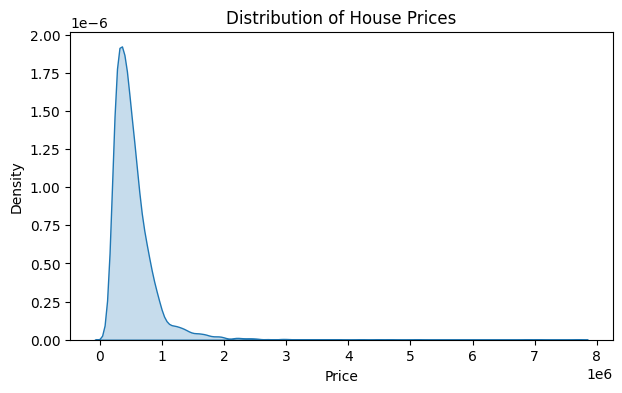

In [14]:
plt.figure(figsize=(7,4))
sns.kdeplot(y_data, fill=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.show()


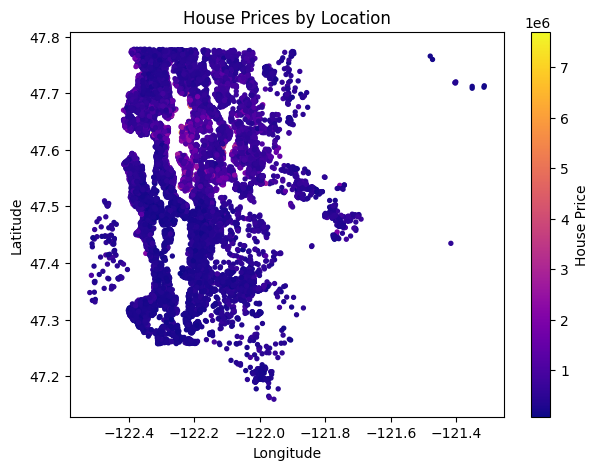

In [15]:
plt.figure(figsize=(7,5))
plt.scatter(
    train_df["long"],
    train_df["lat"],
    c=train_df[target_feature],
    cmap="plasma",
    s=8
)
plt.colorbar(label="House Price")
plt.title("House Prices by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


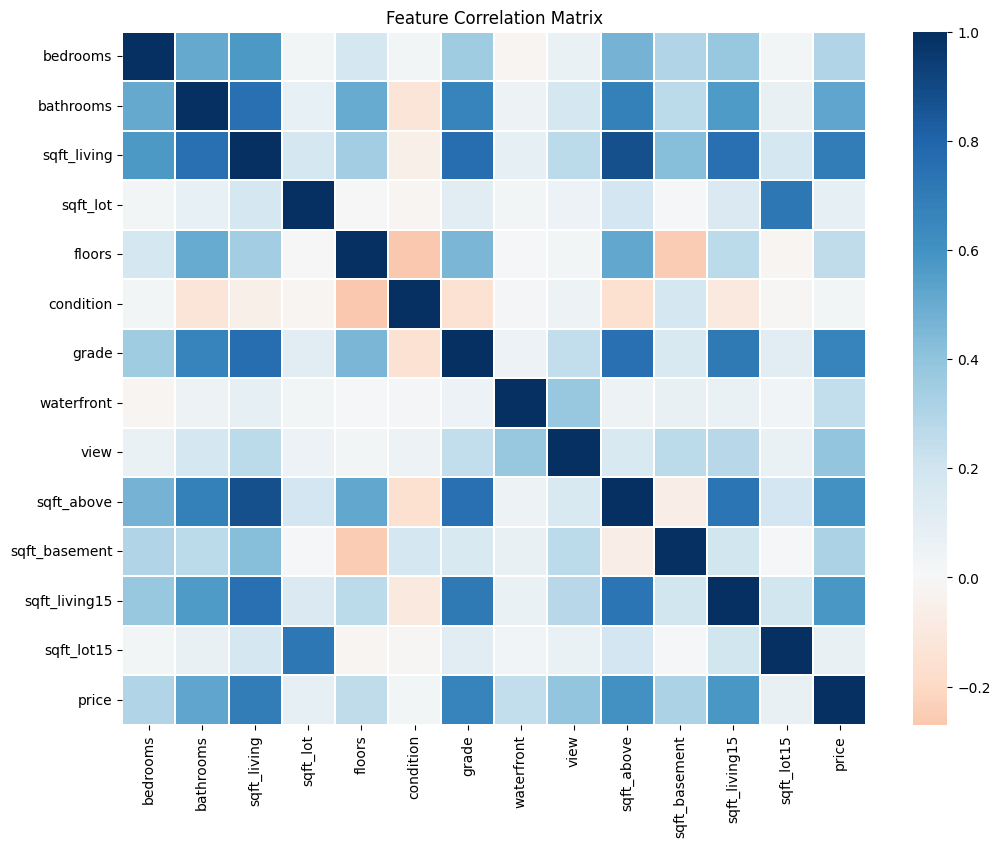

In [16]:
plt.figure(figsize=(12,9))
corr_data = train_df[feature_list + [target_feature]].corr()

sns.heatmap(
    corr_data,
    cmap="RdBu",
    center=0,
    linewidths=0.3
)

plt.title("Feature Correlation Matrix")
plt.show()


# Model **Training**

In [17]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


In [18]:
X_train = np.load("X_train.npy")
X_valid = np.load("X_valid.npy")
y_train = np.load("y_train.npy")
y_valid = np.load("y_valid.npy")
X_test  = np.load("X_test.npy")

test_meta = pd.read_csv("test2(test(1)).csv")


In [19]:
class HousingDataset(Dataset):
    def __init__(self, features, targets=None):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = None if targets is None else torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, index):
        if self.targets is None:
            return self.features[index]
        return self.features[index], self.targets[index]


In [20]:
train_data = HousingDataset(X_train, y_train)
valid_data = HousingDataset(X_valid, y_valid)
test_data  = HousingDataset(X_test)

train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=64)
test_dl  = DataLoader(test_data, batch_size=64)


In [21]:
class PricePredictor(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).view(-1)


In [22]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    losses = []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)


In [23]:
def evaluate(model, loader, device):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            outputs = model(xb).cpu().numpy()
            predictions.extend(outputs)
            actuals.extend(yb.numpy())

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    return rmse, r2


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_model = PricePredictor(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 12

for epoch in range(epochs):
    train_loss = train_one_epoch(
        nn_model, train_dl, optimizer, loss_fn, device
    )

    val_rmse, val_r2 = evaluate(
        nn_model, valid_dl, device
    )

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Loss: {train_loss:.3f} | "
        f"RMSE: {val_rmse:.2f} | "
        f"R2: {val_r2:.3f}"
    )


Epoch 1/12 | Loss: 421066567205.726 | RMSE: 640622.45 | R2: -2.323
Epoch 2/12 | Loss: 418298051573.221 | RMSE: 636069.45 | R2: -2.276
Epoch 3/12 | Loss: 407357181391.495 | RMSE: 623123.23 | R2: -2.144
Epoch 4/12 | Loss: 384180322735.158 | RMSE: 599406.70 | R2: -1.909
Epoch 5/12 | Loss: 347880958232.253 | RMSE: 563653.77 | R2: -1.573
Epoch 6/12 | Loss: 300208732483.368 | RMSE: 517487.26 | R2: -1.168
Epoch 7/12 | Loss: 246800527058.189 | RMSE: 464514.61 | R2: -0.747
Epoch 8/12 | Loss: 195804954322.189 | RMSE: 412551.30 | R2: -0.378
Epoch 9/12 | Loss: 153915015297.347 | RMSE: 368577.71 | R2: -0.100
Epoch 10/12 | Loss: 124161893990.400 | RMSE: 336943.68 | R2: 0.081
Epoch 11/12 | Loss: 105916091963.284 | RMSE: 317356.42 | R2: 0.184
Epoch 12/12 | Loss: 95546286230.905 | RMSE: 305837.14 | R2: 0.243


In [25]:
xgb_reg = XGBRegressor(
    n_estimators=500,
    learning_rate=0.08,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=7
)

xgb_reg.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [26]:
val_preds = xgb_reg.predict(X_valid)

rmse_xgb = np.sqrt(mean_squared_error(y_valid, val_preds))
r2_xgb = r2_score(y_valid, val_preds)

print("XGBoost Performance")
print("RMSE:", rmse_xgb)
print("R²:", r2_xgb)


XGBoost Performance
RMSE: 184456.94357220604
R²: 0.7244959473609924


In [27]:
final_predictions = xgb_reg.predict(X_test)

submission = pd.DataFrame({
    "id": test_meta["id"],
    "predicted_price": final_predictions
})

submission.to_csv("house_price_predictions.csv", index=False)
print("Submission file saved successfully!")


Submission file saved successfully!
